# Tutorial

In [2]:
from IPython.display import display, Image
%matplotlib inline
import matplotlib.pyplot as plt

In [2]:
# these lines of code are to be used if using the binder instance. Ignore otherwise!
import sys
sys.path.append('../../../')
from magine.copy_sample_dbs import copy_sample_databases
# This uses the a cached version of the databases to speed up the tutorial
copy_sample_databases()

Database directories already exist. Override using force=True argument. Skipping...


In [3]:
import pandas as pd
import seaborn as sns
import numpy as np

## ExperimentalData 

Since MAGINE is built for multi-sample, multi-omics data, it is no surprise that the data is the most important aspect. Here we should how to use the `ExperimentalData` class. We designed MAGINE data input to be as flexible as possible, requiring a standard format for 8 columns. Users are required to format the input files to share the same column names. Additional columns can still be used for additional tags on the data. 


| Column | Data type | Description |
| --- | --- | --- |
| identifier | string | HNGC or HMDB ids |
| label | string  | any label that you would like to have as an alterative to identifier. Useful for PTMS (BAX_S(ph)292), aliases, or chemical names (Deoxyuridine) |
| species_type | string | Options (gene, protein, or metabolite) Right now we are trying to work out a more comprehensive tag to use. For now, we suggest using `protein` for all gene related products and use the source column to further distinguish.  |
| significant | bool | used to label if the measurment was signficant compared to control. |
| fold_change | float | Assumes non-log space |
| p_value | float | HNGC or HMDB ids |
| identifier | string | Significance statistic for fold change calculation (can be FDR, BH, etc corrected. |
| source | string | Experimental platform (ie SILAC, PH_SILAC, LABEL_FREE, RNASEQ) |
| sample_id | string | Used to identify sample (time points, drug dose, etc)|


For this tutorial, we are going to use our time series multi-omic response of A549 cells to cisplatin. 

The description of the experiments and dataset can be found in  [Norris, Jeremy L., et al.](https://pubs.acs.org/doi/abs/10.1021/acs.jproteome.6b01004)


This file is in the format as show above in the table. 




In [4]:
# load the experimental data
from magine.data.experimental_data import load_data

exp_data = load_data('Data/norris_et_al_2017_cisplatin_data.csv.gz', low_memory=False)

### About the data


This dataset consists of 6 experimental platforms across 4 time points. The ExperimentData class is designed to explore these data in a seamless way. The core of the class is a pandas.DataFrame, however we built additional functions that we frequently used. We store meta data, such as the `sample_ids`, `exp_methods`.

In [5]:
exp_data.sample_ids

['01hr', '06hr', '24hr', '48hr']

In [6]:
exp_data.exp_methods

['rna_seq', 'ph_silac', 'label_free', 'silac', 'C18', 'HILIC']

There are many functions built around the ExperimentalData class. This notebook is meant to demostrate an examples workflow of how they can be used. Please refer to the documentation for exhuastive information about the functions.

### Summary of data
Gather number of measured species per time point and platform.

In [7]:
exp_data.create_summary_table()

sample_id,01hr,06hr,24hr,48hr,Total Unique Across
source,,,,,
C18,522,227,653,685,1402
HILIC,471,605,930,613,1504
label_free,2766,2742,2551,2261,3447
ph_silac,2608,3298,3384,3236,5113
rna_seq,18741,19104,19992,-,20642
silac,2923,3357,3072,3265,4086


Count number of significantly changed (signficant_flag=True).

In [8]:
exp_data.create_summary_table(sig=True)

sample_id,01hr,06hr,24hr,48hr,Total Unique Across
source,,,,,
C18,522,227,653,685,1402
HILIC,471,605,930,613,1504
label_free,196,46,271,874,1085
ph_silac,514,888,1227,851,2278
rna_seq,73,1999,12215,-,12340
silac,38,52,228,266,485


MAGINE uses the `identifier` column as the default index. This keeps things simple when using the output for other tools (passing to molecular networks). You can also pass an index argument to calculate other values. Here, we use the `label` column, which contains PTMs of our protein species. See how `rna_seq` values do not change, but there is an increase number of `ph_silac` unique species. 

In [9]:
exp_data.create_summary_table(sig=True, index='label')

sample_id,01hr,06hr,24hr,48hr,Total Unique Across
source,,,,,
C18,528,227,657,689,1412
HILIC,479,611,941,621,1521
label_free,201,46,281,911,1149
ph_silac,594,1370,2414,1368,4757
rna_seq,73,1999,12215,-,12340
silac,38,52,228,266,485


### Filter  by category (experimental method)

We can access the input data using the `.species` property. This returns a modified pandas.Datatable.

In [10]:
exp_data.species.head(5)

,identifier,label,species_type,fold_change,p_value,significant,sample_id,source
0,HOXD1,HOXD1_rnaseq,protein,-520.256762,0.00102,True,06hr,rna_seq
1,MIR7704,MIR7704_rnaseq,protein,-520.256762,0.00102,True,06hr,rna_seq
2,AC078814.1,AC078814.1_rnaseq,protein,-76.022260,0.00102,True,06hr,rna_seq
3,PPM1H,PPM1H_rnaseq,protein,-76.022260,0.00102,True,06hr,rna_seq
4,PLCH1,PLCH1_rnaseq,protein,-17.888990,0.00102,True,06hr,rna_seq


We added attributes to the classs to quickly separate the data based on various input columns.
We use the `species_type` and `source` column name to split data into `compounds`, `genes` (includes `species_type`==`gene`), `rna` (includes `species_type`==`protein`, `source` == `rna`), or `protein` (`species_type`==`gene`, `source` != `rna`). 
They can be accessed with the ".prefix", such as

In [11]:
exp_data.genes.head(5)

,identifier,label,species_type,fold_change,p_value,significant,sample_id,source
0,HOXD1,HOXD1_rnaseq,protein,-520.256762,0.00102,True,06hr,rna_seq
1,MIR7704,MIR7704_rnaseq,protein,-520.256762,0.00102,True,06hr,rna_seq
2,AC078814.1,AC078814.1_rnaseq,protein,-76.022260,0.00102,True,06hr,rna_seq
3,PPM1H,PPM1H_rnaseq,protein,-76.022260,0.00102,True,06hr,rna_seq
4,PLCH1,PLCH1_rnaseq,protein,-17.888990,0.00102,True,06hr,rna_seq


In [12]:
exp_data.compounds.head(5)

,identifier,label,species_type,fold_change,p_value,significant,sample_id,source
128152,HMDB0036114,(-)-3-Thujone,metabolites,1.6,2.100000e-02,True,06hr,C18
128153,HMDB0001320,"(13E)-11a-Hydroxy-9,15-dioxoprost-13-enoic acid",metabolites,88.8,5.800000e-12,True,24hr,C18
128154,HMDB0012113,(22Alpha)-hydroxy-campest-4-en-3-one,metabolites,100.0,9.500000e-04,True,48hr,HILIC
128155,HMDB0010361,"(23S)-23,25-dihdroxy-24-oxovitamine D3 23-(bet...",metabolites,-100.0,1.000000e-12,True,48hr,C18
128156,HMDB0011644,"(24R)-Cholest-5-ene-3-beta,7-alpha,24-triol",metabolites,1.6,7.400000e-05,True,01hr,C18


Similarily, we can also filter the data by `source` using the `.name`, where name is anything in the `source` column. We can get a list of these by printing `exp_data.exp_methods`. 


In [13]:
# prints all the available exp_methods
exp_data.exp_methods

['rna_seq', 'ph_silac', 'label_free', 'silac', 'C18', 'HILIC']

In [14]:
# filters to only the 'label_free' 
exp_data.label_free.shape

(13085, 8)

In [15]:
exp_data.label_free.head(5)

,identifier,label,species_type,fold_change,p_value,significant,sample_id,source
102446,LIMS1,LIMS1_lf,protein,12.42,0.00003,True,01hr,label_free
102447,SMARCE1,SMARCE1_lf,protein,-2.49,0.00030,True,01hr,label_free
102448,HEXA,HEXA_lf,protein,6.42,0.00060,True,01hr,label_free
102449,SRSF1,SRSF1_lf,protein,-3.21,0.00060,True,01hr,label_free
102450,SF3B1,SF3B1_lf,protein,-1.57,0.00130,True,01hr,label_free


In [16]:
exp_data.HILIC.head(5)

,identifier,label,species_type,fold_change,p_value,significant,sample_id,source
128154,HMDB0012113,(22Alpha)-hydroxy-campest-4-en-3-one,metabolites,100.0,0.000950,True,48hr,HILIC
128157,HMDB0011644,"(24R)-Cholest-5-ene-3-beta,7-alpha,24-triol",metabolites,1.7,0.000072,True,24hr,HILIC
128162,HMDB0012114,"(3S)-3,6-Diaminohexanoate",metabolites,-1.9,0.000030,True,06hr,HILIC
128164,HMDB0012114,"(3S)-3,6-Diaminohexanoate",metabolites,-3.0,0.002000,True,24hr,HILIC
128166,HMDB0012115,"(3S,5S)-3,5-Diaminohexanoate",metabolites,-1.9,0.000030,True,06hr,HILIC


### Significant filter 
We can use the `significant` column to filter that data to only contain those species by applying `.sig` .

In [17]:
exp_data.species.shape

(132932, 8)

In [18]:
exp_data.species.sig.shape

(27288, 8)

In [19]:
exp_data.label_free.sig.head(5)

,identifier,label,species_type,fold_change,p_value,significant,sample_id,source
102446,LIMS1,LIMS1_lf,protein,12.42,0.00003,True,01hr,label_free
102447,SMARCE1,SMARCE1_lf,protein,-2.49,0.00030,True,01hr,label_free
102448,HEXA,HEXA_lf,protein,6.42,0.00060,True,01hr,label_free
102449,SRSF1,SRSF1_lf,protein,-3.21,0.00060,True,01hr,label_free
102450,SF3B1,SF3B1_lf,protein,-1.57,0.00130,True,01hr,label_free


### Filter data to up or down regulated species.


For enrichment analysis, we will want to access up-regulated and down-regulated species using `.up` and `.down`.

In [20]:
exp_data.label_free.up.head(5)

,identifier,label,species_type,fold_change,p_value,significant,sample_id,source
102446,LIMS1,LIMS1_lf,protein,12.42,0.00003,True,01hr,label_free
102448,HEXA,HEXA_lf,protein,6.42,0.00060,True,01hr,label_free
102451,USP15,USP15_N-term A(ace)2_lf,protein,18.78,0.00270,True,01hr,label_free
102460,SBDS,SBDS_lf,protein,2.79,0.00560,True,01hr,label_free
102488,CLIC4,CLIC4_lf,protein,2.03,0.01880,True,01hr,label_free


In [21]:
exp_data.label_free.down.head(5)

,identifier,label,species_type,fold_change,p_value,significant,sample_id,source
102447,SMARCE1,SMARCE1_lf,protein,-2.49,0.0003,True,01hr,label_free
102449,SRSF1,SRSF1_lf,protein,-3.21,0.0006,True,01hr,label_free
102450,SF3B1,SF3B1_lf,protein,-1.57,0.0013,True,01hr,label_free
102452,CKAP4,CKAP4_lf,protein,-3.26,0.0030,True,01hr,label_free
102453,DDX17,DDX17_lf,protein,-3.08,0.0034,True,01hr,label_free


### Extracting by sample (time point)

We also added an index filter to segregate by `sample_id`.

In [22]:
for i in exp_data.sample_ids:
    print(i)
    display(exp_data[i].head(5))

01hr


,identifier,label,species_type,fold_change,p_value,significant,sample_id,source
19160,GRIK4,GRIK4_rnaseq,protein,77.555651,0.019824,True,01hr,rna_seq
19161,GRIK4_3p_UTR,GRIK4_3p_UTR_rnaseq,protein,77.555651,0.019824,True,01hr,rna_seq
19162,AP001187.9,AP001187.9_rnaseq,protein,-25.455050,0.019824,True,01hr,rna_seq
19163,MIR192,MIR192_rnaseq,protein,-25.455050,0.019824,True,01hr,rna_seq
19164,MIR194-2,MIR194-2_rnaseq,protein,-25.455050,0.019824,True,01hr,rna_seq


06hr


,identifier,label,species_type,fold_change,p_value,significant,sample_id,source
0,HOXD1,HOXD1_rnaseq,protein,-520.256762,0.00102,True,06hr,rna_seq
1,MIR7704,MIR7704_rnaseq,protein,-520.256762,0.00102,True,06hr,rna_seq
2,AC078814.1,AC078814.1_rnaseq,protein,-76.022260,0.00102,True,06hr,rna_seq
3,PPM1H,PPM1H_rnaseq,protein,-76.022260,0.00102,True,06hr,rna_seq
4,PLCH1,PLCH1_rnaseq,protein,-17.888990,0.00102,True,06hr,rna_seq


24hr


,identifier,label,species_type,fold_change,p_value,significant,sample_id,source
37960,LHX3,LHX3_rnaseq,protein,202.225343,0.005180,True,24hr,rna_seq
37961,C17orf67,C17orf67_rnaseq,protein,2.571464,0.000123,True,24hr,rna_seq
37962,ALX1,ALX1_rnaseq,protein,-2.572587,0.000123,True,24hr,rna_seq
37963,MIR7844,MIR7844_rnaseq,protein,2.573033,0.009349,True,24hr,rna_seq
37964,TMCC3,TMCC3_rnaseq,protein,2.573033,0.009349,True,24hr,rna_seq


48hr


,identifier,label,species_type,fold_change,p_value,significant,sample_id,source
58025,TNS3,TNS3_1188_1197_phsilac,protein,-3.837129,0.049,True,48hr,ph_silac
58026,SIPA1L3,SIPA1L3_S(ph)158_phsilac,protein,-5.119600,0.049,True,48hr,ph_silac
58027,TNS3,TNS3_Y(ph)780_phsilac,protein,-4.986421,0.049,True,48hr,ph_silac
58028,FGD6,FGD6_S(ph)554_phsilac,protein,-3.900705,0.049,True,48hr,ph_silac
58029,GPN1,GPN1_S(ph)312_phsilac,protein,2.901199,0.049,True,48hr,ph_silac


In [23]:
exp_data['01hr'].head(5)

,identifier,label,species_type,fold_change,p_value,significant,sample_id,source
19160,GRIK4,GRIK4_rnaseq,protein,77.555651,0.019824,True,01hr,rna_seq
19161,GRIK4_3p_UTR,GRIK4_3p_UTR_rnaseq,protein,77.555651,0.019824,True,01hr,rna_seq
19162,AP001187.9,AP001187.9_rnaseq,protein,-25.455050,0.019824,True,01hr,rna_seq
19163,MIR192,MIR192_rnaseq,protein,-25.455050,0.019824,True,01hr,rna_seq
19164,MIR194-2,MIR194-2_rnaseq,protein,-25.455050,0.019824,True,01hr,rna_seq


### Pivot table to get table across time
We also provide a function to quickly pivot the data to for easy export. 

In [24]:
exp_data.label_free.pivoter(
    convert_to_log=False, 
    index='identifier',
    columns='sample_id',
    values=['fold_change', 'p_value']
).head(10)

fold_change                        p_value                    \
sample_id         01hr   06hr   24hr   48hr      01hr     06hr     24hr   
identifier                                                                
A2M           1.040000  1.140  51.93  11.58  0.514800  0.44370  0.24260   
AACS         -1.100000  3.740    NaN    NaN  0.281800  0.26950      NaN   
AAGAB         1.000000 -1.150   1.46  -2.03  0.968100  0.39240  0.84450   
AAK1          1.320000  1.590    NaN   1.72  0.715800  0.18110      NaN   
AAMP         -1.200000 -1.460   1.85   1.78  0.836800  0.55420  0.13640   
AAR2               NaN -1.690    NaN    NaN       NaN  0.96510      NaN   
AARS          0.326667 -0.035  -1.44  -3.12  0.299867  0.62425  0.46725   
AARS2         1.170000    NaN    NaN    NaN  0.253000      NaN      NaN   
AARSD1        1.210000  4.070  -2.05    NaN  0.459700  0.49160  0.78440   
AASDHPPT     -0.330000  1.020   1.07  -1.11  0.709600  0.81160  0.45290   

                     
sample_id      48hr  
identifier           
A2M         0.11130  
AACS            NaN  
AAGAB       0.09760  
AAK1        0.95660  
AAMP        0.32460  
AAR2            NaN  
AARS        0.00045  
AARS2           NaN  
AARSD1          NaN  
AASDHPPT    0.00070

Note that in the previous two examples, we find that there are NaN values. This is because of our experiental data. We can easy check what species are not found in all 4 of our label free experiements.

In [25]:
print(len(exp_data.label_free.present_in_all_columns(
    index='identifier',
    columns='sample_id',
).id_list))

Number in index went from 3447 to 1819
1819


This shows that out of the 3447 unique species measured in label-free proteomics, only 1819 were measured in all time points. What one can do with this information is dependent on the analysis. We can filter by requiring a species to be signficantly changed in at least `n` samples.

In [26]:
print(exp_data.label_free.require_n_sig(n_sig=2).identifier.unique().shape)
print(exp_data.label_free.require_n_sig(n_sig=3).identifier.unique().shape)
print(exp_data.label_free.require_n_sig(n_sig=4).identifier.unique().shape)

(247,)
(53,)
(2,)


It is important to note that this class is basically a hopped up pandas.DataFrame, so the commands can be chained together.

In [27]:
exp_data.label_free.require_n_sig(n_sig=3).pivoter(
    convert_to_log=False, 
    index='identifier',
    columns='sample_id',
    values=['fold_change', 'p_value']
).head(10)

fold_change                         p_value                    \
sample_id         01hr   06hr   24hr    48hr      01hr     06hr     24hr   
identifier                                                                 
COX5A        -2.185000 -1.550 -1.610   5.480  0.121850  0.07850  0.11900   
DAZAP1       -1.860000  1.240  2.040   2.740  0.364050  0.56310  0.08610   
DDX3X        -1.940000  1.090 -1.620  -3.030  0.089000  0.70330  0.05480   
DDX5         -7.623333  1.090 -2.085  -6.160  0.094733  0.59080  0.00725   
ERH          -2.340000 -1.095  1.440   2.020  0.073300  0.48190  0.06335   
FUS          -2.415000  1.200  1.940   2.620  0.096850  0.08740  0.03320   
GPRC5A       -2.450000 -1.160  1.800  31.455  0.099200  0.09660  0.05520   
H1FX         -1.660000 -1.320 -1.540  -6.340  0.095700  0.00250  0.01970   
HNRNPA2B1    -4.365000  1.360  2.600   4.960  0.050550  0.09280  0.05390   
HNRNPC       -4.543333  4.170  2.270   4.920  0.070000  0.15085  0.12120   

                          
sample_id           48hr  
identifier                
COX5A       2.800000e-03  
DAZAP1      1.100000e-03  
DDX3X       2.700000e-03  
DDX5        2.900000e-03  
ERH         1.885000e-02  
FUS         6.000000e-04  
GPRC5A      4.000000e-04  
H1FX        9.345000e-07  
HNRNPA2B1   2.000000e-04  
HNRNPC      3.800000e-03

### Visualization 
We provide commonly used plotting functions.
`.volcano_plot`
`.volcano_by_sample`
`.plot_histogram`
`.plot_species`
`.heatmap`

#### Volcano plots

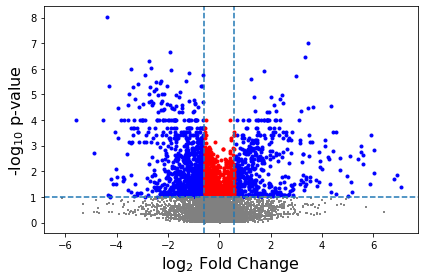

In [28]:
exp_data.label_free.volcano_plot();

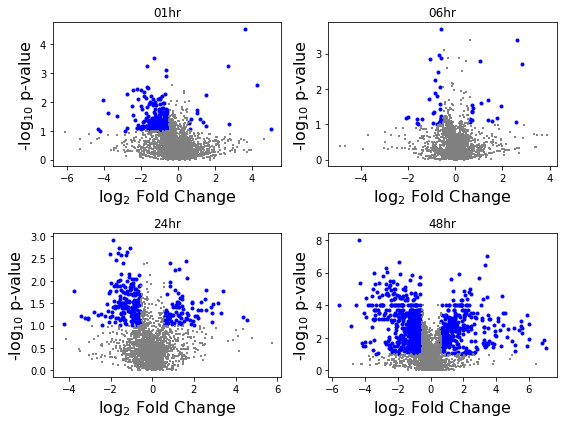

In [29]:
exp_data.label_free.volcano_by_sample(sig_column=True);

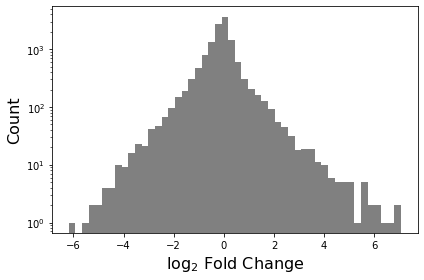

In [30]:
exp_data.label_free.plot_histogram();

### Plotting subset of species

We provide the a few plotting interfaces to explore that subsets of the data. Basically, you create a list of species and provide it to the function. It filters based on these and then returns the results. 


#### Time series using plot'y or matplotlib

In [31]:
exp_data.label_free.plot_species(['LMNA', 'VDAC1'], plot_type='plotly')

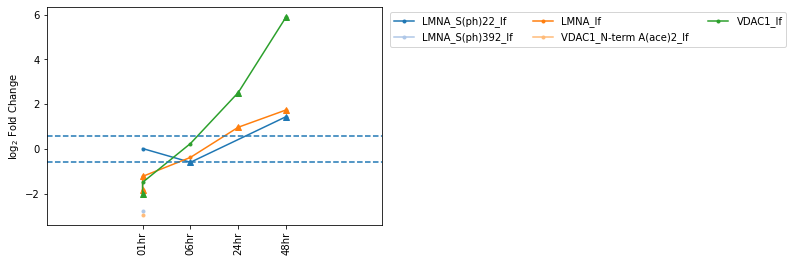

In [32]:
exp_data.label_free.plot_species(['LMNA', 'VDAC1'], plot_type='matplotlib');

#### Heatplots

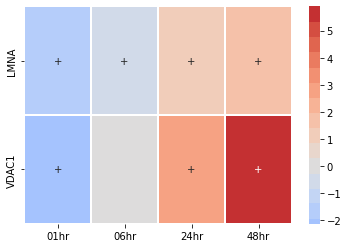

In [33]:
exp_data.label_free.heatmap(
    ['LMNA', 'VDAC1'], 
    figsize=(6,4), 
    linewidths=0.01
);

Notice that the above plot doesn't show any of the modifiers of LMBA (no _s(ph)22_lf). This is because the default index to pivot plots is the `identifier` column. You can set the `label` column for plotting by passing index=`label` to the function. Note, if you want to filter the data using the more generic 'identifier' column, you just specify that with subset_index='identifier'

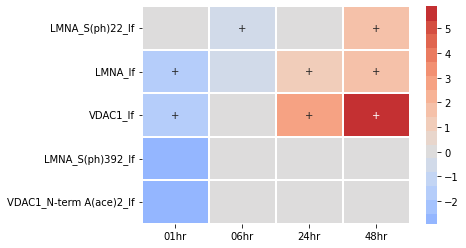

In [34]:
exp_data.label_free.heatmap(
    ['LMNA', 'VDAC1'], 
    subset_index='identifier', 
    index='label',
    figsize=(6,4), 
    linewidths=0.01
);

### Examples

Here are a few examples how all the above commands can be chained together to create plots with varying degrees of critera. 


#### Query 1: 
    Heatmap of label-free proteomics that are signficantly change in at least 3 time points.

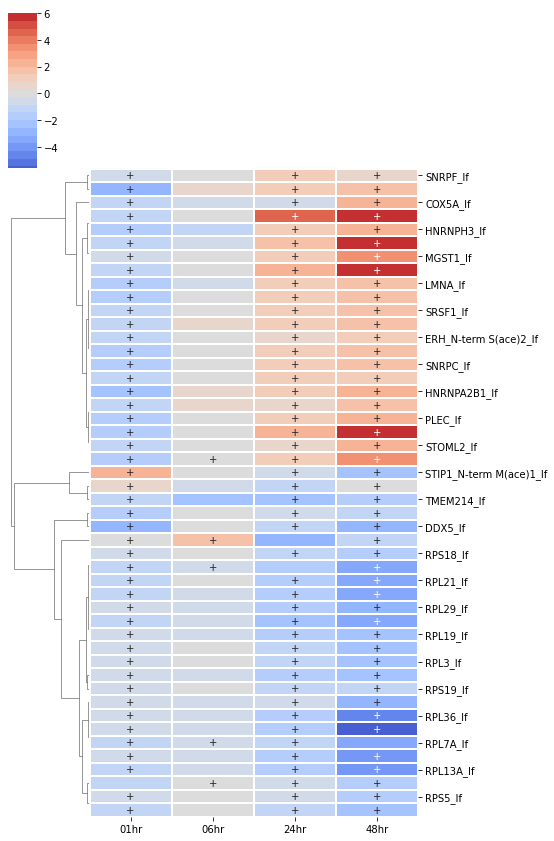

In [35]:
lf_sig = exp_data.label_free.require_n_sig(
    index='label', 
    columns='sample_id', 
    n_sig=3
).heatmap(
    convert_to_log=True, 
    cluster_row=True, 
    index='label',
    values='fold_change', 
    columns='sample_id', 
    annotate_sig=True, 
    figsize=(8, 12), 
    div_colors=True,
    num_colors=21, 
    linewidths=0.01
);

#### Query 2: 
    Changes that happen at all 3 timepoints for RNA-seq.

In [36]:
exp_data.rna.require_n_sig(n_sig=3, index='label').plot_species(plot_type='plotly');

#### Query 3: 
* Heatmap and time series plot of proteins that are consistently down regulated at 3 time points. 

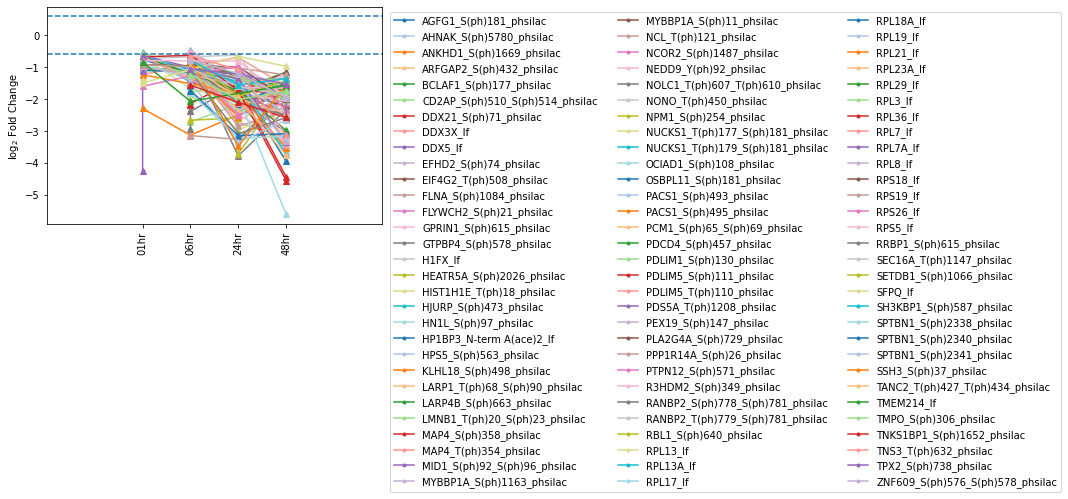

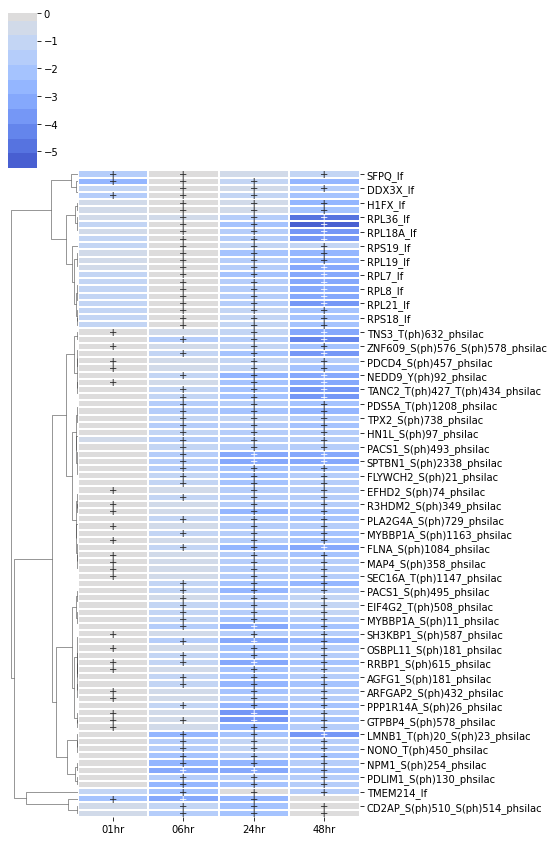

In [37]:
exp_data.proteins.down.require_n_sig(n_sig=3, index='label').plot_species(plot_type='matplotlib');
exp_data.proteins.down.require_n_sig(n_sig=3, index='label').heatmap(index='label', cluster_row=True, linewidths=0.01);

#### Query 4: 
    Clustered heatmap of label-free data

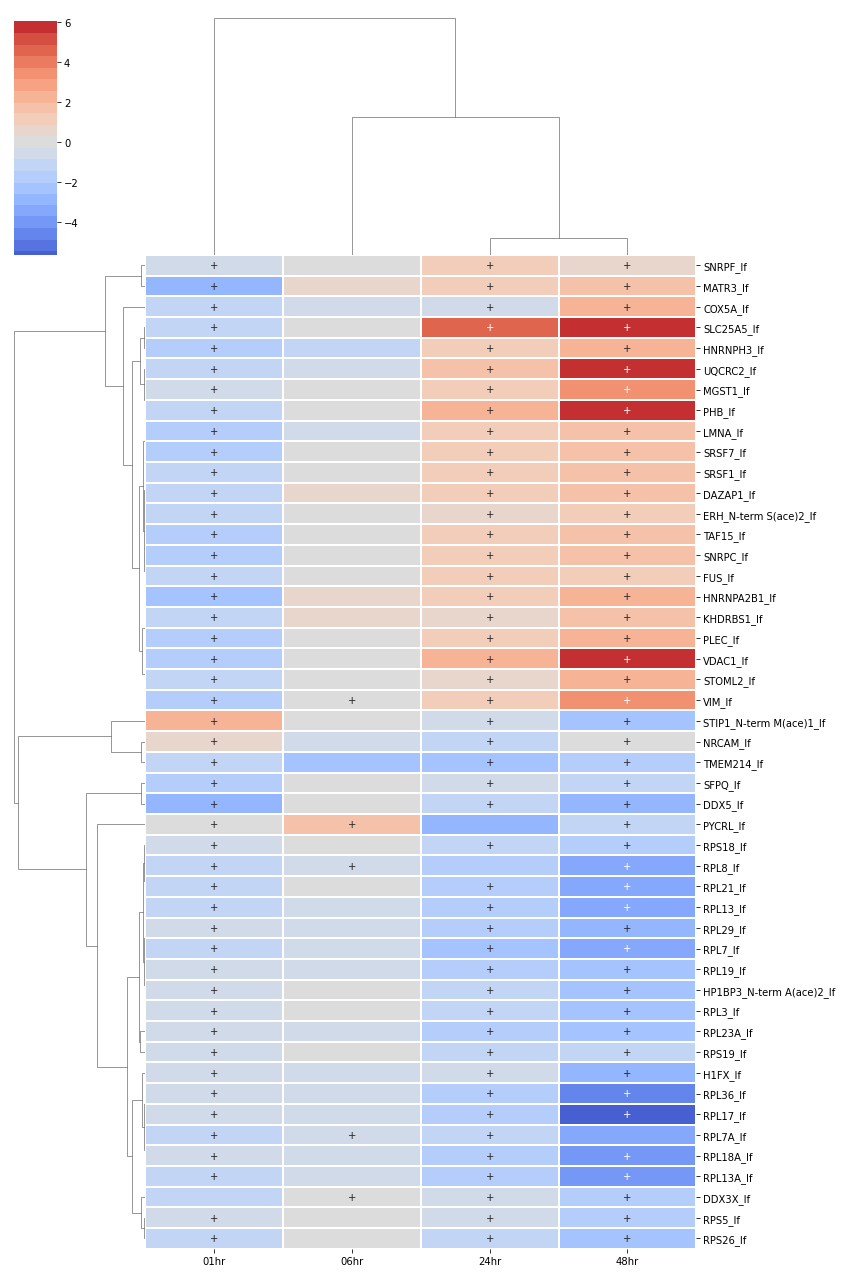

In [38]:
exp_data.label_free.heatmap(
    linewidths=0.01,
    index='label',
    cluster_row=True, 
    cluster_col=True, 
    min_sig=3, 
    figsize=(12,18)
);

### Extending to other plots

Since our exp_data is built off a pandas.DataFrame, we can use other packages that take that data format. Seaborn is one such tool that provides some very nice plots.

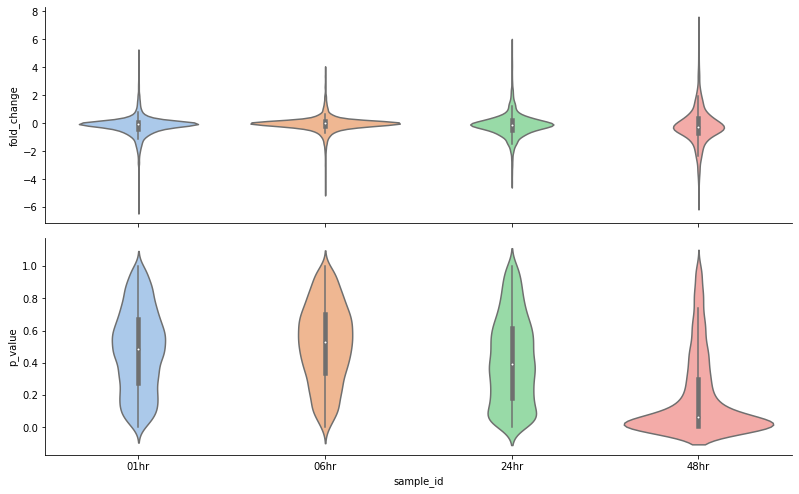

In [39]:
label_free = exp_data.label_free.copy()
label_free.log2_normalize_df(column='fold_change', inplace=True)

g = sns.PairGrid(label_free,
                 x_vars=('sample_id'),
                 y_vars=('fold_change', 'p_value'),
                 aspect=3.25, height=3.5)
g.map(
    sns.violinplot, 
    palette="pastel", 
    order=label_free.sample_ids
);

#### Venn diagram comparisons between measurements

In [40]:
from magine.plotting.venn_diagram_maker import create_venn2, create_venn3

In [41]:
lf = exp_data.label_free.sig

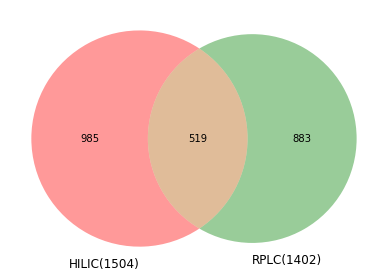

In [42]:
lf = exp_data.label_free.sig.id_list
silac = exp_data.silac.sig.id_list
phsilac = exp_data.ph_silac.sig.id_list
hilic = exp_data.HILIC.sig.id_list
rplc = exp_data.C18.sig.id_list

create_venn2(hilic, rplc, 'HILIC', 'RPLC');

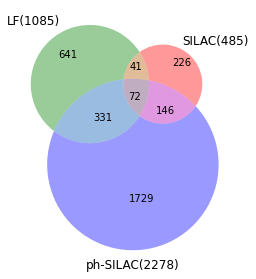

In [43]:
create_venn3(lf, silac, phsilac, 'LF', 'SILAC', 'ph-SILAC');

## Networks

### Create data driven network

MAGINE generates networks using prior knowledge obtained from network databases.
It starts with `seed` species, which are biologically interesting.
This can be from manual curation, based on filtering of data, or a variety of other means.
We locate the seed species in multiple databases and finds interconnecting edges among them. The goal of this process was to obtain all the `known` biological regulation among the species. We currently utilize KEGG, Reactome, HMDB, TTRUST, and BioGrid for node and edge sources.

<img src="assets/network_creation_steps.png" alt="Drawing" style="width: 500px;"/>

In [44]:
# some imports needed
from magine.networks.network_generator import build_network
import magine.networks.utils as utils
import networkx as nx
import os

2021-09-03 13:59:25.008 - magine - INFO - Logging started on MAGINE version 0.1.5
2021-09-03 13:59:25.009 - magine - INFO - Log entry time offset from UTC: -7.00 hours
WARNING [bioservices:UniChem:119]:  The URL (http://www.ebi.ac.uk/unichem/rest) provided cannot be reached.
WARNING [bioservices:UniChem:119]:  UniChem has added new source. Please update the source_ids attribute in bioservices


This is done using the `build_network` function. 
Now we will create the network. We pass the seed (interesting species) and background list (all things measured that we want to make sure are not deleted from the network) to the generator as well as flags turning on all of the network databases. 

In [45]:
measured = exp_data.species.id_list
sig_measured = exp_data.species.sig.id_list
print(len(measured))
print(len(sig_measured))

23725
15777


In [46]:
if not os.path.exists('Data/cisplatin_network.p'):
    network = build_network(
        
        # genes seed species
        seed_species=sig_measured, 
        
        # all data measured, used to allow interconnecting nodes that are not in seeds.
        all_measured_list=measured,  
        
        use_biogrid=True,  # expand with biogrid
        use_hmdb=True,  # expand with hmdb
        use_reactome=True,  # expand with reactome
        use_signor=True,  # expand with signor
        trim_source_sink=True,  # remove all source and sink nodes not measured
        save_name='Data/cisplatin_network'
    )
    # add attibutes to graph nodes (measured, measured at which time points, 
    # significantly changed at which time point)
    utils.add_data_to_graph(network, exp_data)
    print("Saving network")
    # write to GML for cytoscape or other program
    nx.write_gml(
        network,
        os.path.join('Data', 'cisplatin_network_w_attributes.gml')
    )

    # write to gpickle for fast loading in python
    nx.write_gpickle(
        network,
        os.path.join('Data', 'cisplatin_based_network.p'),
    )
else:
    # Load the network, note that it is returned above but for time limits,
    # we will just load the generated one.
    network = nx.read_gpickle('Data/cisplatin_based_network.p')



In [47]:
print(network.number_of_nodes())
print(network.number_of_edges())

13308
181300


As you might iMAGINE, the larger number of input nodes and source databases, the larger the resulting network. 13308 nodes and 181300 edges are too much to manually explore. Thus, we are going to use the `Subgraph` Class to being to query the network. We developed multiple tools to subgraph and explore the network, as well as multiple visualizations.

### Explore subgraphs of network

In [48]:
from magine.networks.subgraphs import Subgraph
from magine.networks.visualization import draw_igraph, draw_graphviz, draw_mpl, draw_cyjs
net_sub = Subgraph(network)

In [49]:
bax_neighbors = net_sub.neighbors(
    'BAX', # node of interest
    upstream=True, # include upstream nodes
    downstream=False,  # include downstream nodes
    include_only=exp_data.species.sig.id_list # limit nodes to only significant changed species
)

There are multiple ways to visualize the network.
draw_igraph, draw_mpl, draw_graphviz, draw_cyjs. The draw_cyjs provides interactive networks within the browser. It shouldn't be used for extremely large networks. There is also some issues with exporting these views when converting the notebooks to other formats (such as web documentation).

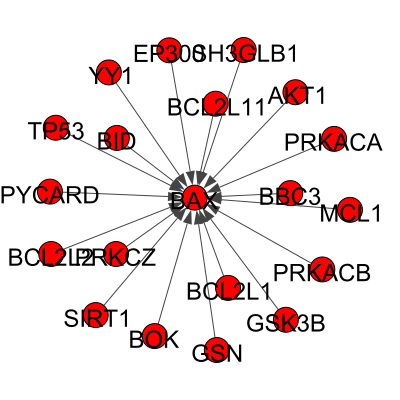

In [50]:
draw_igraph(bax_neighbors, bbox=[400, 400], node_size=25, inline=True)

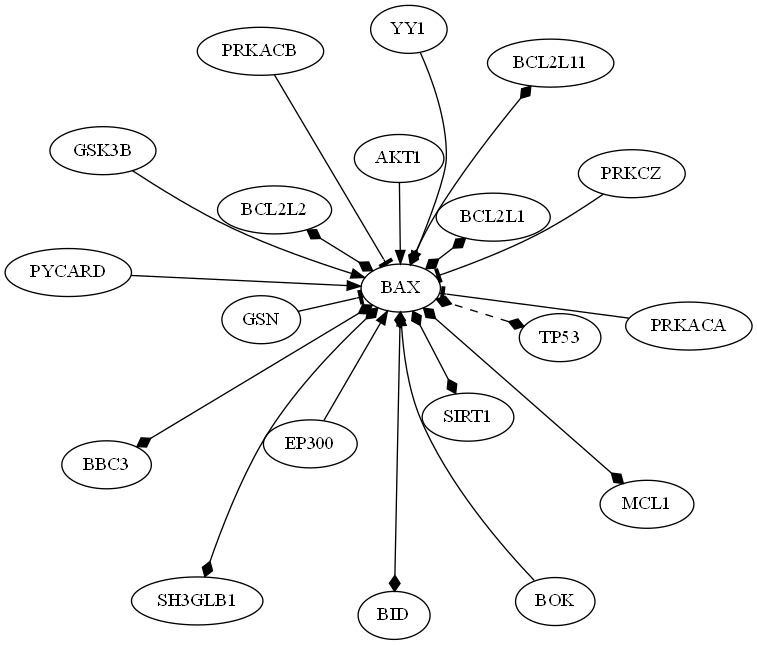

In [51]:
draw_graphviz(bax_neighbors, 'fdp')

In [59]:
draw_cyjs(bax_neighbors)

This network can be exanded by a single or list of nodes passed.

In [60]:
expand = net_sub.expand_neighbors(bax_neighbors, nodes='BID', downstream=True)

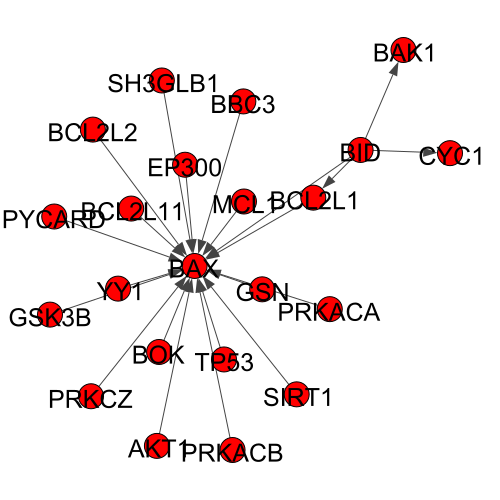

In [61]:
draw_igraph(expand, 
            bbox=[500, 500], 
            node_font_size=25,
            font_size=4,
            node_size=25, 
            inline=True, 
            layout='graphopt')

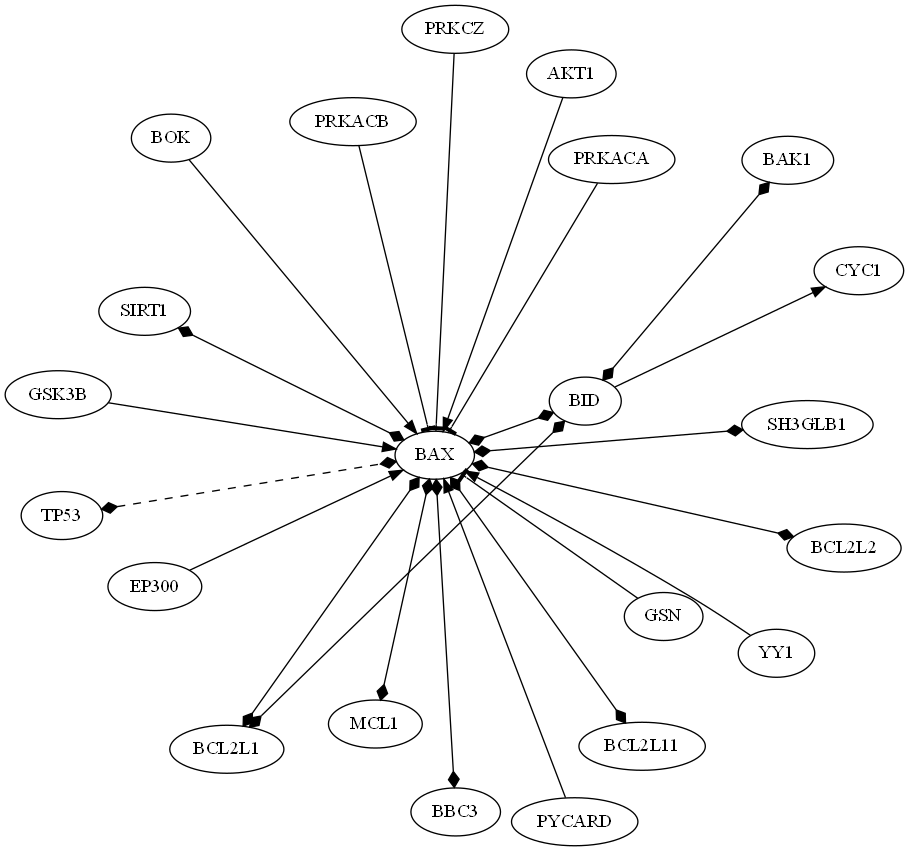

In [62]:
draw_graphviz(expand, 'sfdp', width=700)

#### Finding paths between two proteins

In [63]:
BAX_to_AKT = net_sub.paths_between_pair('NOTCH1', 'MYC', bidirectional=True)

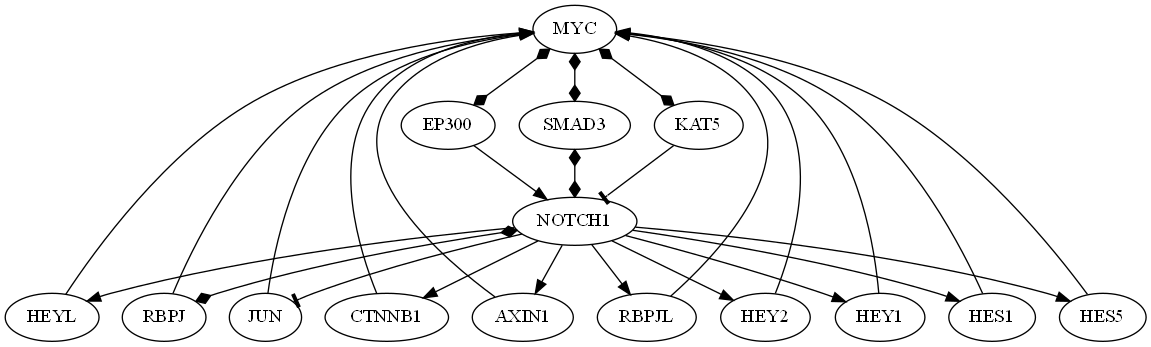

In [64]:
draw_graphviz(BAX_to_AKT)

In [65]:
draw_cyjs(BAX_to_AKT)

### Running enrichment analysis via EnrichR

MAGINE automates the upload samples to EnrichR and collated the results into a user friends format (`EnrichmentResult` Class).
<img src="assets/magine_enrichment.png" alt="Drawing" style="width: 500px;"/>

In [66]:
from magine.enrichment.enrichr import Enrichr

In [67]:
e = Enrichr()

Consistantly down RNA

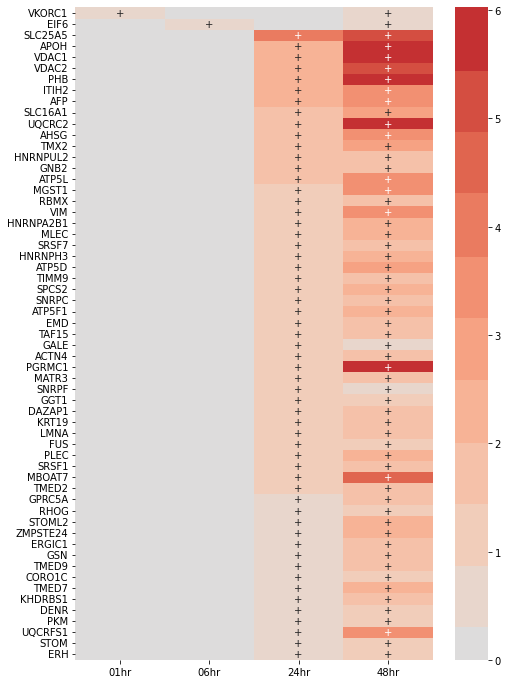

In [78]:
const_dn_lf = exp_data.label_free.up.require_n_sig(n_sig=2, index='label')
const_dn_lf.heatmap();

In [ ]:
# single sample, single background gene set
enrich_dn_lf = e.run(const_dn_lf.id_list, gene_set_lib= 'Reactome_2016')
enrich_dn_lf.head(10)

In [85]:
enrich_dn_lf.term_name = enrich_dn_lf.term_name.str.split('_').str.get(0)
enrich_dn_lf.head(10)

,term_name,rank,p_value,z_score,combined_score,adj_p_value,genes,n_genes,db,significant
0,mrna splicing - major pathway,1,0.000003,17.523290,224.549447,0.000275,"FUS,HNRNPA2B1,RBMX,SNRPF,SRSF1,SRSF7",6,Reactome_2016,True
1,mrna splicing,2,0.000004,16.245283,201.396704,0.000275,"FUS,HNRNPA2B1,RBMX,SNRPF,SRSF1,SRSF7",6,Reactome_2016,True
2,apoptotic cleavage of cellular proteins,3,0.000004,43.874380,543.247522,0.000275,"GSN,LMNA,PLEC,VIM",4,Reactome_2016,True
3,caspase-mediated cleavage of cytoskeletal prot...,4,0.000005,118.642857,1442.061152,0.000275,"GSN,PLEC,VIM",3,Reactome_2016,True
4,the citric acid (tca) cycle and respiratory el...,5,0.000006,15.243743,183.651472,0.000275,"ATP5D,ATP5F1,ATP5L,SLC16A1,UQCRC2,UQCRFS1",6,Reactome_2016,True
5,formation of atp by chemiosmotic coupling,6,0.000013,82.120879,922.112457,0.000510,"ATP5D,ATP5F1,ATP5L",3,Reactome_2016,True
6,apoptotic execution phase,7,0.000015,30.783752,341.143188,0.000510,"GSN,LMNA,PLEC,VIM",4,Reactome_2016,True
7,"respiratory electron transport, atp synthesis ...",8,0.000017,17.661147,193.585769,0.000510,"ATP5D,ATP5F1,ATP5L,UQCRC2,UQCRFS1",5,Reactome_2016,True
8,processing of capped intron-containing pre-mrna,9,0.000022,11.958834,128.249699,0.000575,"FUS,HNRNPA2B1,RBMX,SNRPF,SRSF1,SRSF7",6,Reactome_2016,True
9,mrna splicing - minor pathway,10,0.000486,21.747813,165.908608,0.011427,"SNRPF,SRSF1,SRSF7",3,Reactome_2016,True


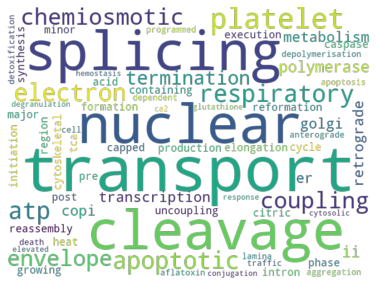

In [83]:
from magine.plotting.wordcloud_tools import create_wordcloud
wc = create_wordcloud(enrich_dn_lf.sig)
wc.plot();

### Multi-timepoint enrichment analysis
We can also run enrichment analysis across multiple samples. The resulting output is similar to the ExperimentalData class, but designed around functions for futrther enrichment analysis. This class is the EnrichementResult class. First let's run the enrichment for each ph-silac sample. We need a list of those species by sample and the sample ids to place them in our results. We can access these with : `exp_data.ph_silac.sig.up_by_sample`, `exp_data.ph_silac.sig.sample_ids`.
Here we will run against the Reactome_2016 gene set, but you can also run it across a list of gene sets.

In [87]:
ph_silac_enrichment = e.run_samples(
    exp_data.ph_silac.sig.up_by_sample, 
    exp_data.ph_silac.sig.sample_ids,
    gene_set_lib='Reactome_2016'
)

In [88]:
ph_silac_enrichment.head(10)

,term_name,rank,p_value,z_score,combined_score,adj_p_value,genes,n_genes,db,significant,sample_id
0,cell cycle_hsa-1640170,1,6.097256e-07,3.317719,47.477413,0.00043,"ACD,AKAP9,BRCA1,CDC16,CDC20,CDC7,CLASP2,DCTN1,...",26,Reactome_2016,True,01hr
1,interleukin-2 signaling_hsa-451927,2,1.697041e-06,4.580979,60.865751,0.00055,"AKAP9,BRAF,CNKSR2,CUL3,HAVCR2,INPPL1,IRS2,MAPK...",16,Reactome_2016,True,01hr
2,"interleukin-3, 5 and gm-csf signaling_hsa-512988",3,2.677495e-06,4.410658,56.591512,0.00055,"AKAP9,BRAF,CNKSR2,CUL3,INPPL1,IRS2,MAPK3,MARK3...",16,Reactome_2016,True,01hr
3,interleukin receptor shc signaling_hsa-912526,4,5.589099e-06,4.392809,53.129672,0.00055,"AKAP9,BRAF,CNKSR2,CUL3,INPPL1,IRS2,MAPK3,MARK3...",15,Reactome_2016,True,01hr
4,signalling by ngf_hsa-166520,5,5.968762e-06,3.332650,40.088346,0.00055,"AKAP13,AKAP9,ARHGEF16,BRAF,CNKSR2,CUL3,HDAC1,I...",21,Reactome_2016,True,01hr
5,mapk family signaling cascades_hsa-5683057,6,7.859464e-06,4.027363,47.336790,0.00055,"AKAP9,BRAF,CNKSR2,CUL3,DNAJB1,IRS2,MAPK3,MARK3...",16,Reactome_2016,True,01hr
6,insulin receptor signalling cascade_hsa-74751,7,8.967430e-06,3.982165,46.280367,0.00055,"AKAP9,BRAF,CNKSR2,CUL3,INSR,IRS2,MAPK3,MARK3,P...",16,Reactome_2016,True,01hr
7,signaling by interleukins_hsa-449147,8,9.805077e-06,3.453619,39.829245,0.00055,"AKAP9,BRAF,CNKSR2,CUL3,HAVCR2,INPPL1,IRS2,MAP3...",19,Reactome_2016,True,01hr
8,signal attenuation_hsa-74749,9,1.022501e-05,43.755556,502.780826,0.00055,"INSR,IRS2,MAPK3,SHC1",4,Reactome_2016,True,01hr
9,signaling by fgfr2_hsa-5654738,10,1.150341e-05,3.551082,40.385980,0.00055,"AKAP9,BRAF,CNKSR2,CUL3,HNRNPA1,HNRNPM,INSR,IRS...",18,Reactome_2016,True,01hr


Term names from enrichR follow various formats, depending on the library and when it was created. We provide some tools to clean them up, but since the EnrichmentResult is based on pandas.Dataframe, we suggest users clean/shorten names to their liking.

In [89]:
# clean up naming of terms
ph_silac_enrichment.term_name = ph_silac_enrichment.term_name.str.split('_').str.get(0)

In [90]:
ph_silac_enrichment.head(10)

,term_name,rank,p_value,z_score,combined_score,adj_p_value,genes,n_genes,db,significant,sample_id
0,cell cycle,1,6.097256e-07,3.317719,47.477413,0.00043,"ACD,AKAP9,BRCA1,CDC16,CDC20,CDC7,CLASP2,DCTN1,...",26,Reactome_2016,True,01hr
1,interleukin-2 signaling,2,1.697041e-06,4.580979,60.865751,0.00055,"AKAP9,BRAF,CNKSR2,CUL3,HAVCR2,INPPL1,IRS2,MAPK...",16,Reactome_2016,True,01hr
2,"interleukin-3, 5 and gm-csf signaling",3,2.677495e-06,4.410658,56.591512,0.00055,"AKAP9,BRAF,CNKSR2,CUL3,INPPL1,IRS2,MAPK3,MARK3...",16,Reactome_2016,True,01hr
3,interleukin receptor shc signaling,4,5.589099e-06,4.392809,53.129672,0.00055,"AKAP9,BRAF,CNKSR2,CUL3,INPPL1,IRS2,MAPK3,MARK3...",15,Reactome_2016,True,01hr
4,signalling by ngf,5,5.968762e-06,3.332650,40.088346,0.00055,"AKAP13,AKAP9,ARHGEF16,BRAF,CNKSR2,CUL3,HDAC1,I...",21,Reactome_2016,True,01hr
5,mapk family signaling cascades,6,7.859464e-06,4.027363,47.336790,0.00055,"AKAP9,BRAF,CNKSR2,CUL3,DNAJB1,IRS2,MAPK3,MARK3...",16,Reactome_2016,True,01hr
6,insulin receptor signalling cascade,7,8.967430e-06,3.982165,46.280367,0.00055,"AKAP9,BRAF,CNKSR2,CUL3,INSR,IRS2,MAPK3,MARK3,P...",16,Reactome_2016,True,01hr
7,signaling by interleukins,8,9.805077e-06,3.453619,39.829245,0.00055,"AKAP9,BRAF,CNKSR2,CUL3,HAVCR2,INPPL1,IRS2,MAP3...",19,Reactome_2016,True,01hr
8,signal attenuation,9,1.022501e-05,43.755556,502.780826,0.00055,"INSR,IRS2,MAPK3,SHC1",4,Reactome_2016,True,01hr
9,signaling by fgfr2,10,1.150341e-05,3.551082,40.385980,0.00055,"AKAP9,BRAF,CNKSR2,CUL3,HNRNPA1,HNRNPM,INSR,IRS...",18,Reactome_2016,True,01hr


The `EnrichmentResult` Class shares the same plotting format as the `ExperimentalData` Class, so we can resuse a lot of the commands we demonstrated earlier. 

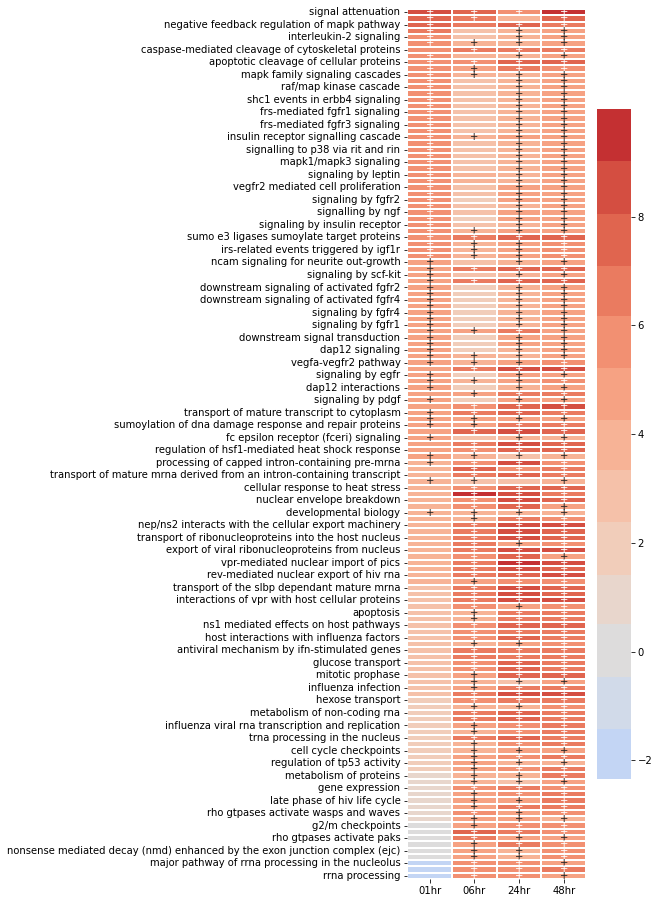

In [101]:
ph_silac_enrichment.require_n_sig(n_sig=3, inplace=True)
ph_silac_enrichment.heatmap(
    figsize=(4,16),
    linewidths=0.01,
    cluster_by_set=False
);

In [103]:
print(len(ph_silac_enrichment.sig.term_name.unique()))

139


#### Term compression
The above plot seems really busy. There are 139 enriched terms. If we look at the top ranked terms, we see that some fo them have similar descriptions ".... fgfr signaling". If we look at the gene list, we can also see that some of the genes are similar. To see if there are redundant terms that are enriched, we can calculate their similarity with the Jaccard Index (intersection over union).
![width=50](https://wikimedia.org/api/rest_v1/media/math/render/svg/eaef5aa86949f49e7dc6b9c8c3dd8b233332c9e7)
<img src="https://upload.wikimedia.org/wikipedia/commons/c/c7/Intersection_over_Union_-_visual_equation.png" alt="Drawing" style="width: 75;"/>

In [107]:
# calculate the Jaccard Index and returns a ranked dataframe of terms and scores.
# Higher scores means more similar terms
d = ph_silac_enrichment.find_similar_terms('cell cycle, mitotic')
display(d.head(20))

,term_name,similarity_score
85,viral messenger rna synthesis,1.0
490,ns1 mediated effects on host pathways,1.0
447,export of viral ribonucleoproteins from nucleus,1.0
61,viral messenger rna synthesis,1.0
60,glucose transport,1.0
59,mitotic prophase,1.0
120,m phase,1.0
57,host interactions with influenza factors,1.0
56,ns1 mediated effects on host pathways,1.0
55,nuclear pore complex (npc) disassembly,1.0


We can do this for all terms and view the results in a distance matrix (plot used for visualization purpose only).

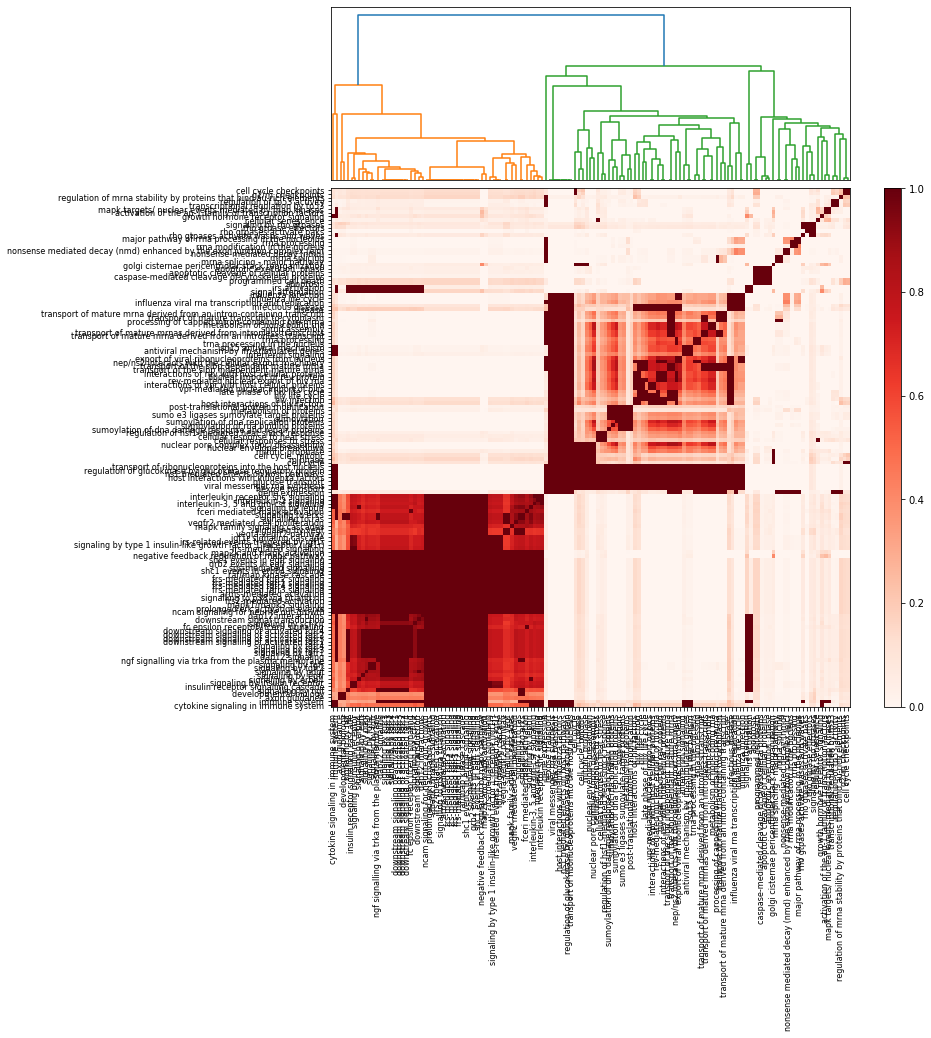

In [108]:
ph_silac_enrichment.dist_matrix(figsize=(12, 12));

We can remove the redundant ones to compress the array. Here, we sort the terms by combined_score. For each term, we calculate the Jaccard index with all other terms. If a term falls below above a user defined threshold, it will be removed in the resulting array. By doing so, we minimize the total number of terms, while maximizing the information content of the resulting array.

In [113]:
ph_silac_enrichment_slim = ph_silac_enrichment.remove_redundant(level='dataframe')

Number of rows went from 139 to 29


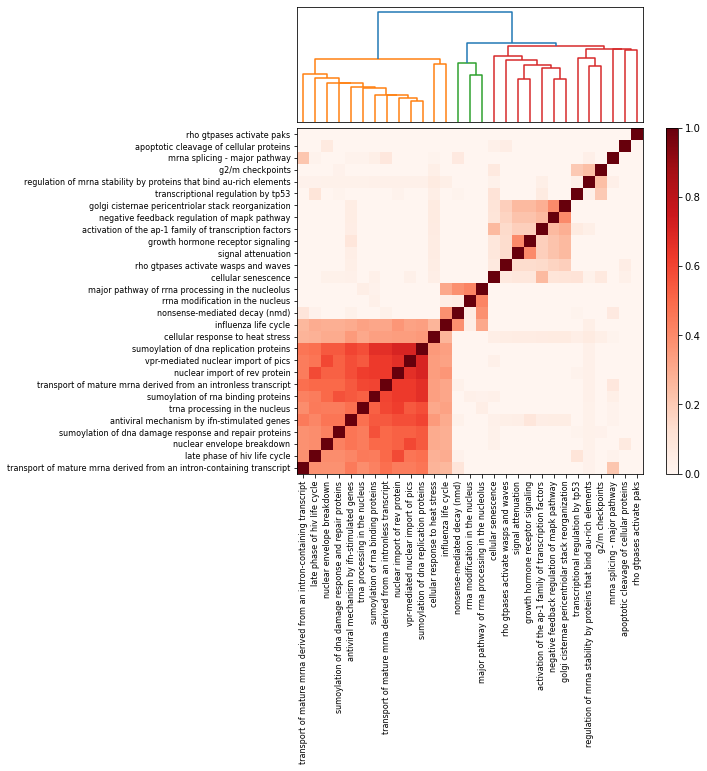

In [114]:
# notive the reduction in size and overlap of terms
ph_silac_enrichment_slim.dist_matrix();

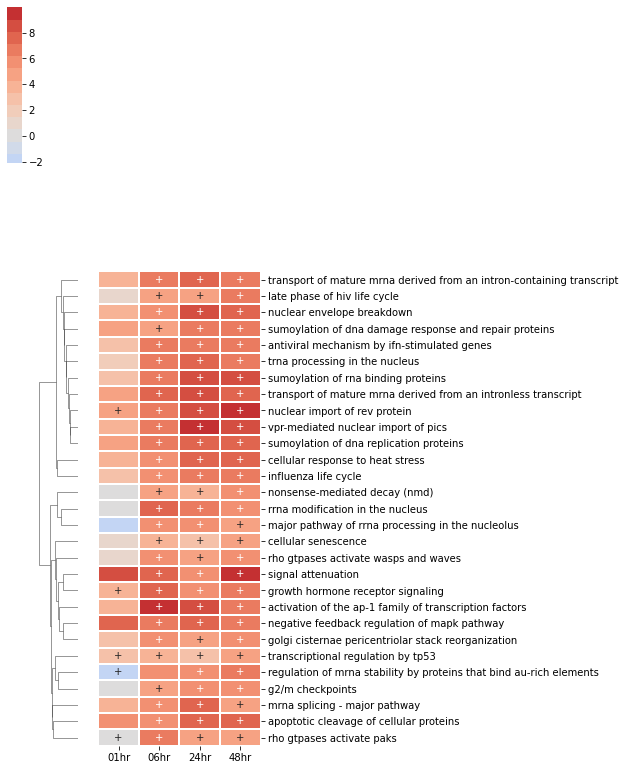

In [116]:
ph_silac_enrichment_slim.heatmap(
    min_sig=2, 
    figsize=(4,12),
    linewidths=0.01,
    cluster_by_set=True
);

Important to known, we can still recover the terms removed based on the highest level term kept.

Number of rows went from 139 to 28


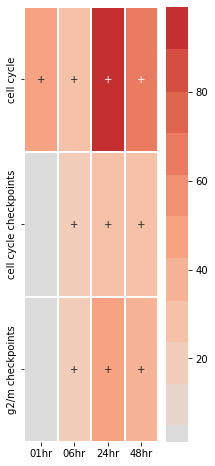

In [117]:
ph_silac_enrichment.show_terms_below('g2/m checkpoints').heatmap(
    linewidths=0.01, 
    convert_to_log=False,
    figsize=(3, 8));

In [119]:
sorted(ph_silac_enrichment_slim.term_name.unique())

['activation of the ap-1 family of transcription factors',
 'antiviral mechanism by ifn-stimulated genes',
 'apoptotic cleavage of cellular proteins',
 'cellular response to heat stress',
 'cellular senescence',
 'g2/m checkpoints',
 'golgi cisternae pericentriolar stack reorganization',
 'growth hormone receptor signaling',
 'influenza life cycle',
 'late phase of hiv life cycle',
 'major pathway of rrna processing in the nucleolus',
 'mrna splicing - major pathway',
 'negative feedback regulation of mapk pathway',
 'nonsense-mediated decay (nmd)',
 'nuclear envelope breakdown',
 'nuclear import of rev protein',
 'regulation of mrna stability by proteins that bind au-rich elements',
 'rho gtpases activate paks',
 'rho gtpases activate wasps and waves',
 'rrna modification in the nucleus',
 'signal attenuation',
 'sumoylation of dna damage response and repair proteins',
 'sumoylation of dna replication proteins',
 'sumoylation of rna binding proteins',
 'transcriptional regulation by t

##### Visualize species of enrichmentt term
We can use the EnrichmentResult to extract out any given set of genes for a term (or the entire array). 
For a select term, we can extract out the species of interest to visualize. This makes chaining together the data, networks, and enrichment output seamlessly.

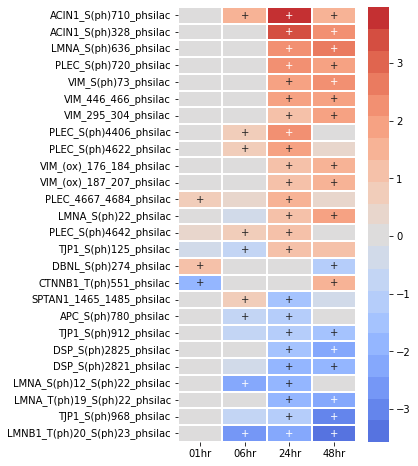

In [118]:
exp_data.ph_silac.heatmap(
    ph_silac_enrichment_slim.sig.term_to_genes('apoptotic cleavage of cellular proteins'),
    subset_index='identifier',
    index='label',
    cluster_row=False,
    sort_row='mean',
    min_sig=2,
    linewidths=0.01,
    figsize=(4, 8),
);

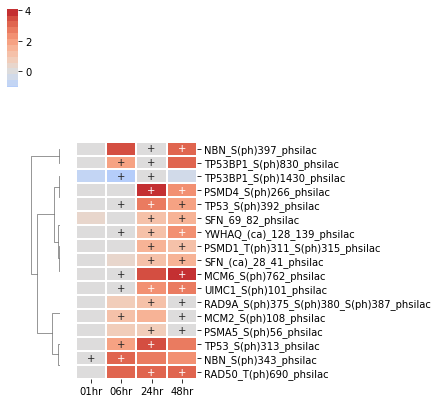

In [120]:
exp_data.ph_silac.heatmap(
    ph_silac_enrichment_slim.sig.term_to_genes('g2/m checkpoints'),
    subset_index='identifier',
    index='label',
    cluster_row=True,
    sort_row='index',
    min_sig=2,
    linewidths=0.01,
    figsize=(3, 6),
);

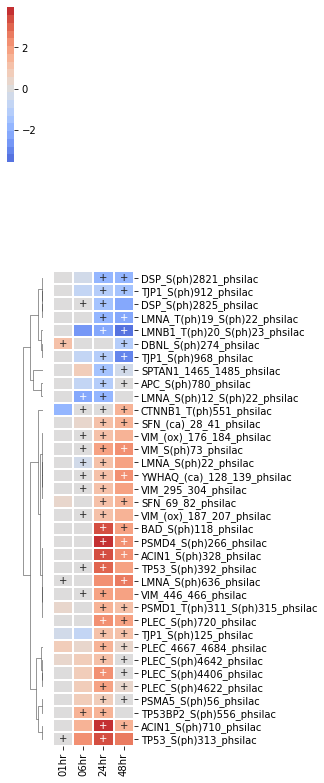

In [121]:
exp_data.ph_silac.heatmap(
    ph_silac_enrichment.sig.term_to_genes('apoptosis'),
    subset_index='identifier',
    index='label',
    cluster_row=True,
    sort_row='index',
    min_sig=2,
    linewidths=0.01,
    figsize=(2,12),
);

##### We can use the ExperimentalData class to filter the data to create lists of genes for further analysis. We take these lists and run enrichment analysis using Enrichr. 

<div>
<img src="assets/magine_enrichment.png" width="500"/>
</div>

Since this part is time consuming, it is best to do it outside of a notebook. The code to do so can be found in "run_enrichment.py". The results will be a csv file that we will load next.

## Annotated Gene set Network (AGN)
Lastly, we created a function to generate molecular and coarse grain networks based on enrichment terms. Users can used the compressed enrichment result terms to generate large scale representations of their data, or by selecting key terms of importance. Here, we are going to use 3 terms from the compressed enrichment result class.

In [122]:
from magine.networks.annotated_set import create_asn
# selected terms of interest
terms=['apoptotic cleavage of cellular proteins', 
       'g2/m checkpoints',
       'transcriptional regulation by tp53']

term_net, mol_net = create_asn(
    ph_silac_enrichment_slim, network,
    terms=terms,
    save_name='all_example',
    use_threshold=True,
    use_cytoscape=False, # If you have cytoscape open, this will create a cytoscape session if True
)

Creating ontology network


In [123]:
draw_cyjs(term_net)

In [124]:
draw_cyjs(mol_net, add_parent=True)

In [125]:
draw_cyjs(mol_net, add_parent=False)

Finally, we can bring it full circle and subset our experimental data to visualize the nodes in the networks measured values over time.

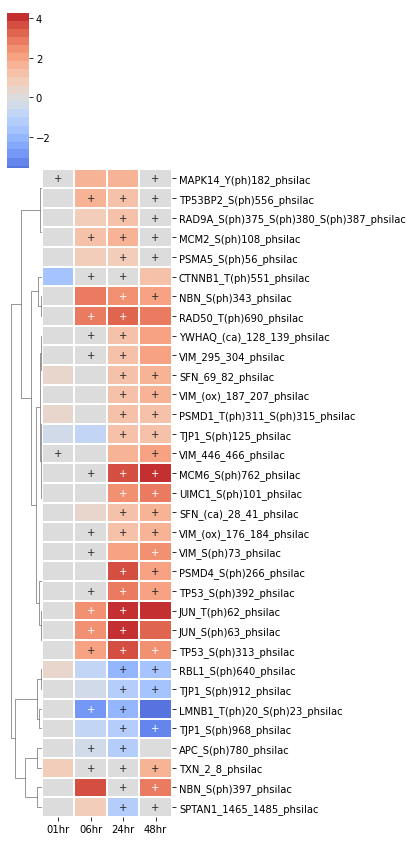

In [127]:
exp_data.ph_silac.heatmap(
    mol_net.nodes,
    subset_index='identifier',
    index='label',
    cluster_row=True,
    sort_row='index',
    min_sig=2,
    linewidths=0.01,
    figsize=(6,12),
);
    

##### Custom workflows
Here we presented some examples of how to use MAGINE. The strength is in MAGINES ability to explore data, enrichment, and networks within a single space, allowing back and forth exploration. If you have any suggestions or would like to contribute workflows or pipelines, please share on our github issues.